## Imports

In [2]:
import copy
import json
import math
import pprint
import random
import scipy
import sklearn.model_selection
import statistics
import matplotlib.pyplot as plt

## Data loading and processing

In [3]:
#ranked_data_path = f"bigresponse_20241102.json"
ranked_data_path = f"export.json"
ranked_data_file = open(ranked_data_path,encoding="utf-8")
ranked_data = json.load(ranked_data_file)

In [7]:
players = ranked_data["Players"]
maps = ranked_data["Maps"]
scores = ranked_data["Scores"]
filtered_scores = [score for score in scores if score["Accuracy"] < 1 and score["Accuracy"] > 0.75]

In [9]:
def sort_by_timepost(score):
    return score["Timepost"]

filtered_scores.sort(key=sort_by_timepost,reverse=True)

perc_by_timepost = 0.35
n_by_timepost = math.floor(perc_by_timepost*len(filtered_scores))

filtered_scores = filtered_scores[0:n_by_timepost]

In [25]:
print(len(filtered_scores))

879172


In [11]:
players_by_id = {player["Id"] : player for player in players}
maps_by_id = {bmap["Id"] : bmap for bmap in maps}

In [13]:
scores_by_player_id = {}
scores_by_map_id = {}

def add_score(score):
    player_id = score["PlayerId"]
    map_id = score["LeaderboardId"]
    
    player_map = scores_by_player_id.get(player_id,{})
    player_map[map_id] = score
    
    scores_by_player_id[player_id] = player_map
    
    map_map = scores_by_map_id.get(map_id,{})
    map_map[player_id] = score
    
    scores_by_map_id[map_id] = map_map
    
#for score in scores:
for score in filtered_scores:
    add_score(score)

In [14]:
modifiers = {"SF":1.05,
             "GN":1,
             "SA":1.02,
             "PM":1,
             "IF":1,
             "NO":0.5,
             "BE":1,
             "SS":0.65,
             "FS":1.02,
             "NB":0.5,
             "SC":1,
             "OD":1,
             "DA":1,
             "CS":1,
             "NA":0.5,
             "OP":0.5}
"""
"SF" - Super Fast,
"GN" - Ghost Notes,
"SA" - Strict Angles,
"PM" - Pro Mode,
"IF" - 1 life,
"NO" - No obstacles (no walls),
"BE" - Battery Energy,
"SS" - Slow song,
"FS" - Fast song,
"NB" - No bombs,
"SC" - Small Notes,
"OD" - Old Dots,
"DA" - Disappearing Arrows,
"CS" - ???,
"NA" - No Arrows -50%,
"OP" - Out of platform -50% 
"""

def modified_score(score,score_modifiers):
    final_score = score
    for modifier,multiplier in modifiers.items():
        if modifier in score_modifiers:
            if multiplier > 1:
                final_score = 1 - (1 - final_score)*(2 - multiplier)
            else:
                final_score = final_score * multiplier
            
    return final_score

## Mathematical functions for transforming and combining numerical values

In [16]:
"""
This is a mapping on the probability space rather than the population space.
That is, from (0,1) to (0,1). A probability distribution on the (0,1) interval.
We can do this with the Beta distribution, though other distributions might work.

I approximate a value for alpha and beta using this: https://homepage.divms.uiowa.edu/~mbognar/applets/beta.html
Trying to get the median around 0.9 and the probability close to 0 for 0.5, but a little bit higher for 0.65ish.
Beat Saber scores are typically at least 65%, on median probably around 0.9. They also must go down as the value
approaches 1, so beta must be greater than 1.

alpha = 10 and beta = 1.25 seemed to work quite well.
"""
#beta_alpha = 10
beta_alpha = 25
#beta_beta = 1.25
beta_beta = 1.02
#beta_max = 20
beta_mean = 10

def beta_value(perc_value, beta_alpha=beta_alpha, beta_beta=beta_beta):
    return scipy.stats.beta.cdf(perc_value, beta_alpha, beta_beta)

def perc_beta_value(beta_value,beta_alpha=beta_alpha, beta_beta=beta_beta):
    return scipy.stats.beta.ppf(beta_value, beta_alpha, beta_beta)

def scaled_beta_value(perc_value, beta_alpha=beta_alpha, beta_beta=beta_beta, beta_mean=beta_mean):
    return beta_mean*beta_value(perc_value,beta_alpha,beta_beta)/beta_value(scipy.stats.beta.mean(beta_alpha, beta_beta))

def scaled_perc_beta_value(value, beta_alpha=beta_alpha, beta_beta=beta_beta, beta_mean=beta_mean):
    return perc_beta_value(value*beta_value(scipy.stats.beta.mean(beta_alpha, beta_beta))/beta_mean,beta_alpha,beta_beta)


In [17]:
"""
There are some issues with this, like that a 100% score could lower a player's skill level
if it is on a very easy map. But this is very unlikely with the numbers, and 100% scores
are exceedingly rare anyway. There are also ways to deal with that later after estimating
difficulties.
"""

# truncexp_max = 25
truncexp_max = 100
# truncexp_base_mean = 7
truncexp_base_mean = 10

def truncexp_value(perc_value,base_mean=truncexp_base_mean,maxx=truncexp_max,beta_alpha=beta_alpha,beta_beta=beta_beta):
    return scipy.stats.truncexpon.ppf(beta_value(perc_value,beta_alpha=beta_alpha,beta_beta=beta_beta),b=maxx,scale=base_mean)

def perc_truncexp_value(truncexp_value,base_mean=truncexp_base_mean,maxx=truncexp_max,beta_alpha=beta_alpha,beta_beta=beta_beta):
    return perc_beta_value(scipy.stats.truncexpon.cdf(truncexp_value,b=maxx,scale=base_mean),beta_alpha=beta_alpha,beta_beta=beta_beta)

In [18]:
"""
We normalize around a value of 7.
This means that a X star player on a 7 accability map achieves an X star score
and a 7 star player on an X accability map achieves an X star score.
"""

#linear_mean = 7
linear_mean = 10

def score_linear(skill,accability,linear_mean = linear_mean):
    return skill * accability / linear_mean

def accability_linear(skill,score,linear_mean = linear_mean):
    return score / skill * linear_mean

def skill_linear(accability,score,linear_mean = linear_mean):
    return score / accability * linear_mean

In [19]:
def abs_prop_error(value,evalue):        
    return abs((value-evalue)/evalue)

def abs_error(value,evalue):
    return abs(value-evalue)

In [20]:
"""
Let's start with something simple: Just use the median instead of the average.
"""

def aggregation_median(scores,default_value=1):
    if scores == []:
        return default_value
    else:
        return statistics.median(scores)
    
def aggregation_median_f(default_value):
    def f(scores):
        return aggregation_median(scores,default_value)
    
    return f

In [21]:
"""
Do the average of the top percentage of scores.
"""
def aggregation_topscores(scores,perc=0.25,default_value=1):
    scores.sort()
    l = len(scores)
    n = math.floor(l*perc)
    
    if n == 0:
        return default_value
    else:
        return statistics.mean(scores[l-n:])
    
def aggregation_topscores_f(perc,default_value):
    def f(scores):
        return aggregation_topscores(scores,perc,default_value)
    
    return f

In [22]:
"""
Do the average of the bottom percentage of scores.
"""
def aggregation_bottomscores(scores,perc=0.25,default_value=1):
    scores.sort()
    l = len(scores)
    n = math.floor(l*perc)
    
    if n == 0:
        return default_value
    else:
        return statistics.mean(scores[0:n])
    
def aggregation_bottomscores_f(perc,default_value):
    def f(scores):
        return aggregation_bottomscores(scores,perc,default_value)
    
    return f

In [23]:
"""
Do the average of the top percentage of scores, but removing outliers
    (Scores that are more than sd_range standard deviations away from the mean)
"""
def aggregation_topscores_nooutliers(scores,perc=0.25,sd_range=3,default_value=1):
    scores.sort()
    l = len(scores)
    n = math.floor(l*perc)
    
    if n < 2:
        return default_value
    else:
        topscores = scores[l-n:]
        mean = statistics.mean(topscores)
        sd = statistics.stdev(topscores)
        
        abs_sd_range = sd*sd_range
        finalscores = [score for score in topscores if abs(score-mean) < abs_sd_range]        
        
        return statistics.mean(finalscores)        
    
def aggregation_topscores_nooutliers_f(perc,sd_range,default_value):
    def f(scores):
        return aggregation_topscores_nooutliers(scores,perc,sd_range,default_value)
    
    return f

## Main algorithm

In [26]:
class BiRating:
    """No description yet"""
    
    def __init__(self,
                 anodes_ratings,bnodes_ratings,
                 wdata,afun,bfun,wfun,
                 aggregation_fun=aggregation_median,
                 default_rating=1,
                 max_iter=50,
                 error_fun=abs_error,
                 error_aggregation_fun=aggregation_bottomscores,
                 finish_early=True,
                 error_change_prop=0.001):
        """
        anodes_ratings and bnodes_ratings must be dictionaries with the node identifiers as keys
        and initial ratings as values.
        
        wdata must be a doubly indexed dictionary with anode identifiers and bnode identifiers as respective indexes,
        respectively, and weights as values.
        
        afun and bfun must be functions taking a value of the other node type as first argument
        and a weight as the second argument, that returns the corresponding value for the node.
        
        Similarly, wfun must be a function that takes the value of an anode and bnode and returns the
        correct weight.
        
        These functions must be such that:
        - wfun(afun(b,w),b) = w
        - wfun(a,bfun(a,w)) = w
        - afun(bfun(a,w),w) = a
        - afun(b,wfun(a,b)) = a
        - bfun(afun(b,w),w) = b
        - bfun(a,wfun(a,b)) = b
        
        error_fun must take two parameters (actual value, expected value) and return a number indicating the error for that
        particular edge
        """
        self.anodes_ratings = anodes_ratings
        self.bnodes_ratings = bnodes_ratings
        
        self.adata = wdata
        self.bdata = self.process_bdata(wdata)
        
        self.afun = afun
        self.bfun = bfun
        self.wfun = wfun
        
        self.aggregation_fun = aggregation_fun
        
        self.error_fun = error_fun
        self.error_aggregation_fun = error_aggregation_fun
        
        self.default_rating = default_rating
        
        self.average_error = math.inf
        
        self.iter = 0
        self.max_iter = max_iter
        
        # Finish early when error increases
        self.finish_early = finish_early
        self.last_average_error = math.inf
        self.last_anodes_ratings = anodes_ratings
        self.last_bnodes_ratings = bnodes_ratings       
    
        self.error_change_prop = error_change_prop
    
    def process_bdata(self, wdata):
        bdata = {}
        
        for anode_id, anode_data in wdata.items():
            for bnode_id, w in anode_data.items():
                bnode_data = bdata.get(bnode_id,{})
                bnode_data[anode_id] = w
                bdata[bnode_id] = bnode_data
        
        return bdata       
        
    def acycle(self):
        for anode_id in self.anodes_ratings:
            if anode_id in self.adata:
                self.anode_process(anode_id)           
            
    def anode_process(self,anode_id):
        anode_data = self.adata.get(anode_id,False)
                
        calc_values = []
        for bnode_id, w in anode_data.items():
            bnode_value = self.bnodes_ratings.get(bnode_id,self.default_rating)
            # asum += clamp(self.afun(bnode_value,w))
            # asum += self.afun(bnode_value,w)
            calc_values.append(self.afun(bnode_value,w))
        
        avg = self.aggregation_fun(calc_values)
        
        # self.anodes_ratings[anode_id] = clamp(avg)
        self.anodes_ratings[anode_id] = avg
    
    def bcycle(self):
        for bnode_id in self.bnodes_ratings:
            if bnode_id in self.bdata:
                self.bnode_process(bnode_id)                
    
    def bnode_process(self,bnode_id):
        bnode_data = self.bdata[bnode_id]
        
        calc_values = []
        for anode_id, w in bnode_data.items():
            anode_value = self.anodes_ratings.get(anode_id,self.default_rating)
            # bsum += clamp(self.bfun(anode_value,w))
            calc_values.append(self.bfun(anode_value,w))
        
        avg = self.aggregation_fun(calc_values)
        
        # self.bnodes_ratings[bnode_id] = clamp(avg)
        self.bnodes_ratings[bnode_id] = avg
    
    def save_last(self):
        self.last_anodes_ratings = self.anodes_ratings
        self.last_bnodes_ratings = self.bnodes_ratings
        self.last_average_error = self.average_error
        
    def restore_last(self):
        self.anodes_ratings = self.last_anodes_ratings
        self.bnodes_ratings = self.last_bnodes_ratings
        self.average_error = self.last_average_error
    
    def iterate(self):
        self.save_last()
        
        self.bcycle()
        self.acycle()
        
        self.average_error = self.measure_error(self.adata)
        
        self.iter += 1        
        print(f"Iteration {self.iter}, Average error: {self.average_error}")         
        
    def run(self):
        while (self.iter <= self.max_iter):            
            self.iterate()
            
            # Finish early with previous result if error went up
            if self.finish_early and (self.average_error > self.last_average_error):
                self.restore_last()
                print(f"Finishing early due to increased average error. Restoring previous values.")
                break
                
            # Finish if the error did not change by more than the error_change_prop
            if self.last_average_error != math.inf:
                abs_error_change = abs(self.average_error - self.last_average_error)
                if (abs_error_change / self.last_average_error) < self.error_change_prop:
                    print(f"Finishing due to change in average error less than {self.error_change_prop} (proportional)")
                    break
                
        return (self.anodes_ratings,self.bnodes_ratings)
    
    def measure_error(self,wdata_test):
        calc_values = []
        for anode_id in wdata_test:
            anode_data = wdata_test[anode_id]
            anode_value = self.anodes_ratings.get(anode_id,self.default_rating)

            for bnode_id, w in anode_data.items():
                bnode_value = self.bnodes_ratings.get(bnode_id,self.default_rating)
                calculated_w = self.wfun(anode_value,bnode_value)
                error = self.error_fun(calculated_w,w)
                calc_values.append(error)
            
        average_error = self.error_aggregation_fun(calc_values)
        
        return average_error      
     

## Prepare scores in the right format

In [24]:
scores_doubly_indexed = {map_id : {player_id : truncexp_value(modified_score(scores_by_map_id[map_id][player_id]["Accuracy"],scores_by_map_id[map_id][player_id]["Modifiers"])) for player_id in scores_by_map_id[map_id]} for map_id in scores_by_map_id}

#scores_doubly_indexed = {map_id : {player_id : scaled_beta_value(modified_score(scores_by_map_id[map_id][player_id]["accuracy"],scores_by_map_id[map_id][player_id]["modifiers"])) for player_id in scores_by_map_id[map_id]} for map_id in scores_by_map_id}

In [142]:
test_set_size = 0.2

scores_doubly_indexed_training_items, scores_doubly_indexed_test_items = sklearn.model_selection.train_test_split(list(scores_doubly_indexed.items()),test_size=test_set_size)
scores_doubly_indexed_training = dict(scores_doubly_indexed_training_items)
scores_doubly_indexed_test = dict(scores_doubly_indexed_test_items)

## Run the algorithm

In [27]:
#default_rating = 7
default_rating = 10
#default_rating = beta_mean

map_ratings = {map_id : default_rating for map_id in scores_by_map_id}
player_ratings = {player_id: default_rating for player_id in scores_by_player_id}

# aggregation_fun = aggregation_median_f(default_rating)
aggregation_topscores_p = 0.9
aggregation_topscores_sd_range = 1
error_aggregation_bottomscores_p = 0.5
aggregation_fun = aggregation_topscores_nooutliers_f(aggregation_topscores_p,aggregation_topscores_sd_range,default_rating)
error_aggregation_fun=aggregation_bottomscores_f(error_aggregation_bottomscores_p,0)

bps = BiRating(map_ratings,player_ratings,scores_doubly_indexed,
#bps = BiRating(map_ratings,player_ratings,scores_doubly_indexed_training,
                          accability_linear,skill_linear,score_linear,
                          aggregation_fun=aggregation_fun,
                          default_rating = default_rating,
                          error_aggregation_fun=error_aggregation_fun,
                          max_iter=50,
                          finish_early=True,
                          error_change_prop=0.005)

#bps.iterate()
#(maps_1,players_1) = (copy.deepcopy(bps.anodes_ratings), copy.deepcopy(bps.bnodes_ratings))
#maps_1_errors = {key:bps.anode_error(key) for key in maps_1}
#bps.iterate()
#(maps_2,players_2) = (copy.deepcopy(bps.anodes_ratings), copy.deepcopy(bps.bnodes_ratings))

(map_ratings,player_ratings) = bps.run()

Iteration 1, Average error: 0.19112380079617372
Iteration 2, Average error: 0.16913404384771916
Iteration 3, Average error: 0.1617871160418034
Iteration 4, Average error: 0.15844148601557875
Iteration 5, Average error: 0.15690236331689522
Iteration 6, Average error: 0.15598423199980027
Iteration 7, Average error: 0.155354607210584
Finishing due to change in average error less than 0.005 (proportional)


## Basic measurement of error

In [28]:
print(bps.measure_error(scores_doubly_indexed_test))

NameError: name 'scores_doubly_indexed_test' is not defined

## Outputting learned ratings

In [143]:
with open('map_ratings_20241219_better_betas.txt', 'w') as f:
    pprint.pprint(map_ratings, width=1, stream=f)
    
with open('player_ratings_20241219_better_betas.txt', 'w') as f:
    pprint.pprint(player_ratings, width=1, stream=f)

## Hyper-parameter search

In [48]:
# Reset the hyper-parameter search result list
# Problem variations. Each of these will have a best result. But they need compared manually.
problem_grid = {
    #"error_aggregation_bottomscores_p": [0.25,0.5,0.75,0.9]
    "error_aggregation_bottomscores_p": [0.5]
}

hs_results = []
for hs_error_aggregation_bottomscores_p in problem_grid["error_aggregation_bottomscores_p"]:
    hs_results.append({
        "problem_params":{"error_aggregation_bottomscores_p":hs_error_aggregation_bottomscores_p},
        "runs":[]
    })

In [133]:
# Fixed parameters
default_rating = 10
truncexp_base_mean = default_rating
linear_mean = default_rating
test_set_size = 0.2
crossvalidation_splits = 5

# Hyperparameter grid. Some may only have one value but in principle it makes sense to explore more.
hyperparam_grid = {
    "beta_alpha": [25],
    "beta_beta": [1.01,1.02,1.05],
    "truncexp_max": [100],
    "aggregation_topscores_p": [0.9],
    "aggregation_topscores_sd_range": [1],
    "max_iter":[50],
    "finish_early": [True],
    "error_change_prop": [0.005]
}

def hyperparam_grid_size(hyperparam_grid):
    result = 1
    for key,values in hyperparam_grid.items():
        result = result*len(values)
        
    return result

print(hyperparam_grid_size(hyperparam_grid))

# This hyper-parameter search is performed more or less manually, for two reasons:
# - It is considerably easier to program and make sure it works.
# - It allows us to optimize some of the operations to not have to re-do them when the parameters that affect it
#  have not changed (e.g. truncexp_max affecting data pre-processing)

for hs_error_aggregation_bottomscores_p in problem_grid["error_aggregation_bottomscores_p"]:
    print(f"error_aggregation_bottomscores_p = {hs_error_aggregation_bottomscores_p}")
    
    for hs_beta_alpha in hyperparam_grid["beta_alpha"]:
        print(f"beta-alpha = {hs_beta_alpha}")
        for hs_beta_beta in hyperparam_grid["beta_beta"]:
            print(f"beta-beta = {hs_beta_beta}")
            hs_beta_value = lambda perc_value : beta_value(perc_value,beta_alpha=hs_beta_alpha,beta_beta=hs_beta_beta)
            hs_perc_beta_value = lambda beta_value : perc_beta_value(beta_value,beta_alpha=hs_beta_alpha,beta_beta=hs_beta_beta)

            for hs_truncexp_max in hyperparam_grid["truncexp_max"]:
                print(f"truncexp_max = {hs_truncexp_max}")
                hs_truncexp_value = lambda perc_value : truncexp_value(perc_value,base_mean=truncexp_base_mean,maxx=hs_truncexp_max,beta_alpha=hs_beta_alpha,beta_beta=hs_beta_beta)
                hs_perc_truncexp_value = lambda truncexp_value : perc_truncexp_value(truncexp_value,base_mean=truncexp_base_mean,maxx=hs_truncexp_max,beta_alpha=hs_beta_alpha,beta_beta=hs_beta_beta)

                hs_scores_doubly_indexed = {map_id : {player_id : hs_truncexp_value(modified_score(scores_by_map_id[map_id][player_id]["accuracy"],scores_by_map_id[map_id][player_id]["modifiers"])) for player_id in scores_by_map_id[map_id]} for map_id in scores_by_map_id}

                hs_score_linear = lambda skill, accability : score_linear(skill,accability,linear_mean = linear_mean)
                hs_accability_linear = lambda skill, score : accability_linear(skill,score,linear_mean = linear_mean)
                hs_skill_linear = lambda accability, score : skill_linear(accability,score,linear_mean = linear_mean)
               
                for hs_aggregation_topscores_p in hyperparam_grid["aggregation_topscores_p"]:
                    print(f"aggregation_topscores_p = {hs_aggregation_topscores_p}")
                    for hs_aggregation_topscores_sd_range in hyperparam_grid["aggregation_topscores_sd_range"]:
                        print(f"aggregation_topscores_sd_range = {hs_aggregation_topscores_sd_range}")
                        for hs_max_iter in hyperparam_grid["max_iter"]:
                            print(f"max_iter = {hs_max_iter}")
                            for hs_finish_early in hyperparam_grid["finish_early"]:
                                print(f"finish_early = {hs_finish_early}")
                                for hs_error_change_prop in hyperparam_grid["error_change_prop"]:
                                    print(f"error_change_prop = {hs_error_change_prop}")

                                    hs_crossvalidation_train_error_mean = 0
                                    hs_crossvalidation_test_error_mean = 0                                
                                    for hs_crossvalidation_i in range(crossvalidation_splits):
                                        print(f"Crossvalidation run {hs_crossvalidation_i}")                                          

                                        hs_scores_doubly_indexed_training_items, hs_scores_doubly_indexed_test_items = sklearn.model_selection.train_test_split(list(hs_scores_doubly_indexed.items()),test_size=test_set_size)
                                        hs_scores_doubly_indexed_training = dict(hs_scores_doubly_indexed_training_items)
                                        hs_scores_doubly_indexed_test = dict(hs_scores_doubly_indexed_test_items)

                                        hs_map_ratings = {map_id : default_rating for map_id in scores_by_map_id}
                                        hs_player_ratings = {player_id: default_rating for player_id in scores_by_player_id}

                                        hs_aggregation_fun = aggregation_topscores_nooutliers_f(hs_aggregation_topscores_p,hs_aggregation_topscores_sd_range,default_rating)
                                        hs_error_aggregation_fun = aggregation_bottomscores_f(hs_error_aggregation_bottomscores_p,0)

                                        hs_bps = BiRating(hs_map_ratings,hs_player_ratings,hs_scores_doubly_indexed_training,
                                                                  hs_accability_linear,hs_skill_linear,hs_score_linear,
                                                                  aggregation_fun=hs_aggregation_fun,
                                                                  default_rating = default_rating,
                                                                  error_aggregation_fun=hs_error_aggregation_fun,
                                                                  max_iter=hs_max_iter,
                                                                  finish_early=hs_finish_early,
                                                                  error_change_prop=hs_error_change_prop)

                                        (hs_map_ratings,hs_player_ratings) = hs_bps.run()

                                        hs_error_train = hs_bps.average_error
                                        hs_error_test = hs_bps.measure_error(hs_scores_doubly_indexed_test)

                                        hs_crossvalidation_train_error_mean += hs_error_train/crossvalidation_splits
                                        hs_crossvalidation_test_error_mean += hs_error_test/crossvalidation_splits

                                    hs_run = {
                                        "hyperparams":{
                                            "default_rating":default_rating,
                                            "truncexp_base_mean":truncexp_base_mean,
                                            "linear_mean":linear_mean,
                                            "test_set_size":test_set_size,
                                            "crosssvalidation_splits":crossvalidation_splits,
                                            "beta_alpha":hs_beta_alpha,
                                            "beta_beta":hs_beta_beta,
                                            "truncexp_max":hs_truncexp_max,
                                            "aggregation_topscores_p":hs_aggregation_topscores_p,
                                            "aggregation_topscores_sd_range":hs_aggregation_topscores_sd_range,
                                            "max_iter":hs_max_iter,
                                            "finish_early":hs_finish_early,
                                            "error_change_prop":hs_error_change_prop
                                        },
                                        "results":{
                                            "train_error":hs_crossvalidation_train_error_mean,
                                            "test_error":hs_crossvalidation_test_error_mean
                                        }
                                    }

                                    pprint.pprint(hs_run,width=1)

                                    hs_runs_found = False
                                    for hs_problem in hs_results:
                                        if hs_problem["problem_params"] == {"error_aggregation_bottomscores_p":hs_error_aggregation_bottomscores_p}:
                                            hs_problem["runs"].append(hs_run)
                                            hs_runs_found = True
                                            break

                                    if not hs_runs_found:
                                        raise

3
error_aggregation_bottomscores_p = 0.5
beta-alpha = 25
beta-beta = 1.01
truncexp_max = 100
aggregation_topscores_p = 0.9
aggregation_topscores_sd_range = 1
max_iter = 50
finish_early = True
error_change_prop = 0.005
Crossvalidation run 0
Iteration 1, Average error: 0.18800106725903243
Iteration 2, Average error: 0.16609038538418722
Iteration 3, Average error: 0.15889814021811327
Iteration 4, Average error: 0.15562790391308984
Iteration 5, Average error: 0.15403122442158607
Iteration 6, Average error: 0.15310177338839015
Iteration 7, Average error: 0.15240967309517398
Finishing due to change in average error less than 0.005 (proportional)
Crossvalidation run 1
Iteration 1, Average error: 0.18971698649386415
Iteration 2, Average error: 0.16738411399958886
Iteration 3, Average error: 0.16010227132357502
Iteration 4, Average error: 0.1570495365584023
Iteration 5, Average error: 0.15540539903001419
Iteration 6, Average error: 0.15442447969200465
Iteration 7, Average error: 0.1538893652779

{'hyperparams': {'aggregation_topscores_p': 0.9,
                 'aggregation_topscores_sd_range': 1,
                 'beta_alpha': 25,
                 'beta_beta': 1.05,
                 'crosssvalidation_splits': 5,
                 'default_rating': 10,
                 'error_change_prop': 0.005,
                 'finish_early': True,
                 'linear_mean': 10,
                 'max_iter': 50,
                 'test_set_size': 0.2,
                 'truncexp_base_mean': 10,
                 'truncexp_max': 100},
 'results': {'test_error': 0.3886241550334142,
             'train_error': 0.1645379621506694}}


In [39]:
pprint.pprint(hs_results,width=1)

[{'problem_params': {'error_aggregation_bottomscores_p': 0.25},
  'runs': [{'hyperparams': {'aggregation_topscores_p': 0.25,
                            'beta_alpha': 10,
                            'beta_beta': 1.25,
                            'crosssvalidation_splits': 5,
                            'default_rating': 10,
                            'error_change_prop': 0.005,
                            'finish_early': False,
                            'linear_mean': 10,
                            'max_iter': 50,
                            'test_set_size': 0.2,
                            'truncexp_base_mean': 10,
                            'truncexp_max': 100},
            'results': {'test_error': 1.0283248730593837,
                        'train_error': 0.5790266175302495}},
           {'hyperparams': {'aggregation_topscores_p': 0.25,
                            'beta_alpha': 10,
                            'beta_beta': 1.25,
                            'crosssvalidation_spl

In [134]:
with open('hyperparam_search_results_20241219_beta_optimization_2.txt', 'w') as f:
    pprint.pprint(hs_results, width=1, stream=f)

In [135]:
for hs_problem in hs_results:
    hs_problem_params = hs_problem["problem_params"]
    hs_runs = hs_problem["runs"]
    
    min_test_error = math.inf
    min_test_error_hyperparams = None
    min_test_error_results = None
    
    for hs_run in hs_runs:
        hs_hyperparams = hs_run["hyperparams"]
        hs_run_results = hs_run["results"]
        hs_test_error = hs_run_results["test_error"]
        
        if hs_test_error < min_test_error:
            min_test_error = hs_test_error
            min_test_error_hyperparams = hs_hyperparams
            min_test_error_results = hs_run_results
    
    print(f"The run with the lowest validation error for problem {hs_problem_params} is the following:")
    pprint.pprint(min_test_error_hyperparams,width=1)
    pprint.pprint(min_test_error_results,width=1)

The run with the lowest validation error for problem {'error_aggregation_bottomscores_p': 0.5} is the following:
{'aggregation_topscores_p': 0.9,
 'aggregation_topscores_sd_range': 1,
 'beta_alpha': 25,
 'beta_beta': 1.02,
 'crosssvalidation_splits': 5,
 'default_rating': 10,
 'error_change_prop': 0.005,
 'finish_early': True,
 'linear_mean': 10,
 'max_iter': 50,
 'test_set_size': 0.2,
 'truncexp_base_mean': 10,
 'truncexp_max': 100}
{'test_error': 0.35014819057985114,
 'train_error': 0.15626234591544}


In [136]:
for hs_problem in hs_results:
    hs_problem_params = hs_problem["problem_params"]
    hs_runs = hs_problem["runs"]
    
    min_train_error = math.inf
    min_train_error_hyperparams = None
    min_train_error_results = None
    
    for hs_run in hs_runs:
        hs_hyperparams = hs_run["hyperparams"]
        hs_run_results = hs_run["results"]
        hs_train_error = hs_run_results["train_error"]
        
        if hs_train_error < min_train_error:
            min_train_error = hs_train_error
            min_train_error_hyperparams = hs_hyperparams
            min_train_error_results = hs_run_results
    
    print(f"The run with the lowest training error for problem {hs_problem_params} is the following:")
    pprint.pprint(min_train_error_hyperparams,width=1)
    pprint.pprint(min_train_error_results,width=1)

The run with the lowest training error for problem {'error_aggregation_bottomscores_p': 0.5} is the following:
{'aggregation_topscores_p': 0.9,
 'aggregation_topscores_sd_range': 1,
 'beta_alpha': 25,
 'beta_beta': 1.01,
 'crosssvalidation_splits': 5,
 'default_rating': 10,
 'error_change_prop': 0.005,
 'finish_early': True,
 'linear_mean': 10,
 'max_iter': 50,
 'test_set_size': 0.2,
 'truncexp_base_mean': 10,
 'truncexp_max': 100}
{'test_error': 0.3585707884642441,
 'train_error': 0.15296351027783453}


## Basic result exploration

In [67]:
map_outliers = {map_id : rating for (map_id,rating) in map_ratings.items() if rating < 3}
player_outliers = {player_id : rating for (player_id,rating) in player_ratings.items() if rating > 30}

In [68]:
print(map_outliers)
print(player_outliers)

{'3b5a9xxxx92': 1.182424713844299, '3db71x91': 2.71152585428254, '2c7ffxxx91': 2.96077659225159, '3e2c2xxxxx91': 1.7001259171626595, '28d74xxxxxx91': 2.4718567154360733, '36bce91': 2.1742392107514843, '3697axxxx91': 1.8859660612226934, '3aa79xxxxxxxxx91': 1.6336068931620304, '3a5afxxx91': 2.9963649143338333, '3b5a9xxxx91': 2.7907049155596595, '2ee3bxxxxxx91': 2.501393627469096, '100991': 2.9374662573837016, '3e2c2xxxxx92': 2.1974332398115375, '2c803x91': 1.9498991975873836, '3bcf5xxxxxxxx91': 1.8578800577879315, '3c0b8xxx91': 2.9622116851207583, '3b531xxxxx91': 2.5942609116938793, '3b2bcxxxx91': 2.072421139720252, '36fb2xxxx91': 2.946106004937191, 'f58391': 2.798404306811071, '3ce7axxxxxxxxxxx91': 1.7413426667241072, '30a33xxx91': 2.656721882812878, '2b4f2xxxxxxx91': 2.737730474712019, '6b5f71': 2.7710191805020674, '3c010xxxxxx91': 2.752607091074989, '2dd6cxx92': 2.115739671314874, '3442cxxx91': 2.1719574247120335, '194291': 2.729665909167974, '387a0xxxx91': 1.9989250763194506, '25737x

In [176]:
hard_maps = {map_id : rating for (map_id,rating) in map_ratings.items() if rating < 0.25}
print(hard_maps)

{'3e2c2xxxxx91': 0.21143468247021688, '3697axxxx91': 0.24651867198367725, '3aa79xxxxxxxxx91': 0.2057058404206233, '3ce7axxxxxxxxxxx91': 0.16430660230282018}


In [182]:
easy_maps = {map_id : rating for (map_id,rating) in map_ratings.items() if rating > 50}
print(easy_maps)

{'7e8f11': 92.0117774802941, '2a57111': 58.030483049209685, '3cafbxx11': 50.98464264520409, '3bb99x11': 53.76678303068287}


In [187]:
good_players = {player_id : rating for (player_id,rating) in player_ratings.items() if rating > 30}
print(good_players)

{'1922350521131465': 33.43132463923502}


In [188]:
#print(scores_doubly_indexed["7e8f11"])
#print(maps_by_id["3cafbxx11"])
print(players_by_id["1922350521131465"])

{'name': 'a literal box of french fries', 'country': 'US', 'id': '1922350521131465', 'avatar': 'https://cdn.assets.beatleader.xyz/1922350521131465R11.png'}


In [ ]:
print(player_ratings["76561199108348236"])

In [ ]:
print(scores_by_player_id["76561199108348236"])

In [ ]:
print(map_ratings["38419x92"])

## Useful stuff for extra detailed exploration

In [ ]:
def errors_in_map(map_id,map_ratings,player_ratings):
    result = {}
    map_rating = map_ratings[map_id]
    for player_id,score in scores_doubly_indexed[map_id].items():
        player_rating = player_ratings[player_id]
        calculated_w = bps.wfun(map_rating,player_rating)
        error = bps.error_fun(calculated_w,score)
        result[player_id] = {"calculated_w":calculated_w,"actual_score":score,"error":error}
        
    return result

In [ ]:
errors_this_map = errors_in_map("1442791",maps_1,players_1)
error_outliers = {player_id:error for (player_id,error) in errors_this_map.items() if error["error"] < 1}
print(error_outliers)

In [ ]:
scores_by_map_id["2c803x91"]["76561198279631500"]

In [ ]:
hard_maps = {map_id : rating for (map_id,rating) in maps_1.items() if rating < 2}
print(hard_maps)

## Extra output processing for sharing

In [4]:
# Load map ratings previously calculated.
with open('map_ratings_20241104_newscores.txt', 'r') as f:
    map_ratings = json.load(f)

In [174]:
def rating_scaling_function(rating):    
    return 94/(6+rating)

In [175]:
scaled_map_ratings = {key:rating_scaling_function(rating) for (key,rating) in map_ratings.items()}

In [176]:
with open('scaled_map_ratings_20241219_better_betas.txt', 'w') as f:
    #pprint.pprint(map_ratings, width=1, stream=f)
    json.dump(scaled_map_ratings,f)

In [177]:
star_rating_diff_threshold = 1.25

# Uses scaled_map_ratings and maps_by_id
def map_markdown_description(key):
    map_data = maps_by_id[key]
    
    name = map_data["name"]
    modeName = map_data["modeName"]
    difficultyName = map_data["difficultyName"]
    ss_rating = map_data["modifiersRating"]["ssStars"]
    estimated_original_stars = ss_rating*8/7    
    scaled_rating = scaled_map_ratings[key]
    
    diff_rating = abs(scaled_rating-estimated_original_stars)
    
    if diff_rating > star_rating_diff_threshold:
        string = f"!! **[{name}({modeName} - {difficultyName})](https://beatleader.xyz/leaderboard/global/{key}/1): {scaled_rating:.1f}** !!"
    else:
        string = f"[{name}({modeName} - {difficultyName})](https://beatleader.xyz/leaderboard/global/{key}/1): {scaled_rating:.1f}"
    
    return string

In [178]:
map_markdown_descriptions = {key:map_markdown_description(key) for key in map_ratings}

In [179]:
with open('map_markdown_descriptions_20241219_better_betas.txt', 'w', encoding="utf-8") as f:    
    for key in sorted(map_markdown_descriptions, key=scaled_map_ratings.get, reverse=True):
        print(map_markdown_descriptions[key], file=f)                

## Graphical representation of results

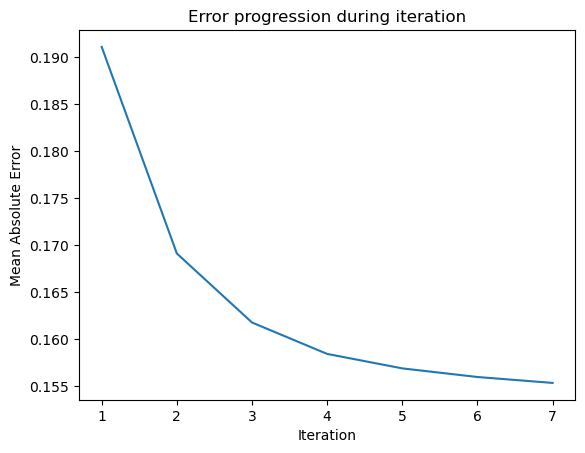

In [33]:
iteration_results_1 = [0.19025348106088535, 0.1682798484012543, 0.16101240672583858, 0.15781771112118528, 0.15612611944062493, 0.15514038376679856, 0.1544977920175717]
iteration_results_2 = [0.19112380079617372, 0.16913404384771916, 0.1617871160418034, 0.15844148601557875, 0.15690236331689522, 0.15598423199980027, 0.155354607210584]

indexes_2 = range(1,len(iteration_results_2)+1)

plt.plot(indexes_2,iteration_results_2)
plt.xlabel("Iteration")
plt.ylabel("Mean Absolute Error")
plt.title("Error progression during iteration")
plt.show()

## Quick tests

In [22]:
array = random.sample(range(10000),30)
print(array)
print(aggregation_topscores_nooutliers(array,perc=0.5,sd_range=1))

[1979, 6959, 2507, 8800, 6243, 859, 5074, 3465, 8992, 5014, 914, 5894, 7371, 8366, 719, 2624, 4184, 378, 8331, 9662, 2174, 2054, 818, 4942, 2848, 7407, 8350, 6986, 8190, 4929]
Topscores:[5014, 5074, 5894, 6243, 6959, 6986, 7371, 7407, 8190, 8331, 8350, 8366, 8800, 8992, 9662]
Mean:7442.6, SD:1413.888447812324
Final scores:[6243, 6959, 6986, 7371, 7407, 8190, 8331, 8350, 8366, 8800]
7700.3


In [43]:
print(filtered_scores[0:10])
print(len(filtered_scores))

[{'id': 18899072, 'leaderboardId': '2c9e4x71', 'accuracy': 0.8319306, 'modifiers': '', 'playerId': '76561198253195606', 'timepost': 1730530450}, {'id': 18899068, 'leaderboardId': '1bfe511', 'accuracy': 0.9512127, 'modifiers': '', 'playerId': '300821', 'timepost': 1730530428}, {'id': 18899066, 'leaderboardId': '2698d11', 'accuracy': 0.9910254, 'modifiers': 'DA,SF', 'playerId': '76561198287046923', 'timepost': 1730530416}, {'id': 18899061, 'leaderboardId': '1ffad51', 'accuracy': 0.9750992, 'modifiers': '', 'playerId': '76561198931790806', 'timepost': 1730530392}, {'id': 18899058, 'leaderboardId': '74371', 'accuracy': 0.8384286, 'modifiers': '', 'playerId': '76561198047750567', 'timepost': 1730530353}, {'id': 18899054, 'leaderboardId': '1ccb951', 'accuracy': 0.9441963, 'modifiers': 'SC', 'playerId': '300821', 'timepost': 1730530331}, {'id': 18899050, 'leaderboardId': '103fb31', 'accuracy': 0.94624966, 'modifiers': '', 'playerId': '76561199072746579', 'timepost': 1730530303}, {'id': 188990

In [126]:
print(map_ratings["1c26891"])

9.095285710124978


In [38]:
support = [x/100 for x in range(100)]

betas = [beta_value(x) for x in support]
truncexp = [truncexp_value(x) for x in support]

In [140]:
points = [0.5,0.75,0.8,0.85,0.9,0.92,0.94,0.95,0.96,0.97,0.98,0.99,0.9999,1]
for point in points:
    print(f"{point} - {scaled_beta_value(point)} - {scaled_perc_beta_value(scaled_beta_value(point))}")

0.5 - 0.04164245354372734 - 0.5
0.75 - 2.0929815366108673 - 0.75
0.8 - 3.833456620662342 - 0.8
0.85 - 6.6960722713724055 - 0.85
0.9 - 11.152216464430692 - 0.9000000000000001
0.92 - 13.479742947378947 - 0.92
0.94 - 16.136438290343914 - 0.94
0.95 - 17.580955143646204 - 0.95
0.96 - 19.090991524834077 - 0.96
0.97 - 20.64785809030468 - 0.97
0.98 - 22.216947400721434 - 0.98
0.99 - 23.726460879750427 - 0.99
0.9999 - 24.917315683298288 - 0.9999
1 - 24.92128523940592 - 1.0


In [130]:
perc_beta_value(11*beta_value(scipy.stats.beta.mean(beta_alpha, beta_beta))/beta_mean,beta_alpha,beta_beta)

0.8985851272877177

In [139]:
scaled_perc_beta_value(11)

0.8985851272877177

In [134]:
perc_beta_value(11*beta_value(scipy.stats.beta.mean(beta_alpha, beta_beta))/beta_mean,beta_alpha,beta_beta)

0.8985851272877177